In [123]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib import style
from collections import Counter
import re
from geotext import GeoText
from wordcloud import WordCloud
from PIL import Image
import math
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import string
import random
import pickle
from sklearn.cross_validation import train_test_split
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

style.use('fivethirtyeight')


In [105]:
# constants
DATA_PATH = '../data/'
JOBS_PATH = DATA_PATH + 'jobs/'
IMG_PATH = DATA_PATH + 'images/'

In [106]:
try:
    df = pd.read_pickle(JOBS_PATH + 'monster-jobs.pickle')
except FileNotFoundError:
    df = pd.read_csv(JOBS_PATH + 'monster-jobs.csv',encoding = 'ISO-8859-1')
    df.to_pickle(JOBS_PATH + 'monster-jobs.pickle')

LENGTH = len(df)

In [107]:
descriptions = df['job_description']
job_titles = df['job_title']
organization = df['organization']
sector = df['sector']

In [108]:
stop_words = set(stopwords.words('english'))
# additional stop words found in dataset
additional_stop_words = set(['Job','OpportunityAffirmative','Opportunity', 'monster','Most', 'Date', 'Apex', 'monster.com','Monstercom','Monster com' 'MONS_LOG_VARS', 'var', 'ejb_header', 'JobID', 'Of', ])
stop_words = stop_words.union(additional_stop_words)

In [109]:
'''
returns a counter object containing all locations mined from location column
'''
def get_location_counter(column):
    all_noun_tokens = []
    location_tokens = []
    
    for elm in column:
        # tokenize location as a sentence
        # needed because some elements contain alot of text
        sent = sent_tokenize(elm)
        for sent_tok in sent:
            # tokenize sentece
            words = word_tokenize(sent_tok)
            # tag words by part of speech
            tagged = nltk.pos_tag(words)
            nouns = []
            # collect all proper nouns
            for tup in tagged:
                if tup[1] == 'NNP':
                    nouns.append(tup[0])
            all_noun_tokens.append(nouns)
    
    for token in all_noun_tokens:
        tagged = nltk.pos_tag(token)
        # create named entity from all nouns
        namedEnt = nltk.ne_chunk(tagged, binary=True)
        for ent in namedEnt:
            if(hasattr(ent, 'label') and ent.label() == 'NE'):
                location_str = ' '.join(e[0] for e in ent)
                # find combined entities such as San Jose, Las Vegas, etc
                loc = GeoText(location_str)
                if(len(loc.cities) > 0):
                    location_tokens.append(location_str.title())
    return Counter(location_tokens)

'''
creates word cloud of locations mined from dataset
focuses on cities
'''
def make_US_word_cloud(locations):
    # https://lollyjane.com/wp-content/uploads/2014/05/free-united-states-silhouette.jpg
    us_img = np.array(Image.open('../data/images/us-stencil.png'))
    
    wc = WordCloud(background_color="white", max_words=2000, mask=us_img,
                  stopwords=stop_words)
    wc.generate_from_frequencies(locations)
    wc.to_file(IMG_PATH + 'location-word-cloud.png')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [110]:
locations = df['location']
loc_counter = get_location_counter(locations)

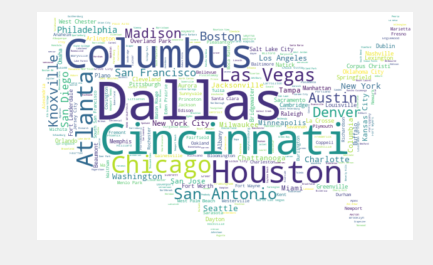

In [111]:
make_US_word_cloud(loc_counter)

In [112]:
'''
function to strip word of any location and punctuation and replaces punctuation with space 
'''
def strip_word_remove_location(word):
    # map punctuation to space
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    word = word.translate(translator)
    loc = GeoText(word)
    return word if len(loc.cities) == 0 and word != 'nan' else ''

def get_counter_object(column):
    all_tokens = []
    for row in column:
        words = word_tokenize(str(row))
        for word in words:
            word = strip_word_remove_location(word)
            word = word.strip()
            if (not word in stop_words and len(word) > 0):
                all_tokens.append(word)
    return Counter(all_tokens)

In [149]:
org_counter = get_counter_object(organization).most_common(100)
sec_counter = get_counter_object(sector).most_common(100)
desc_counter = get_counter_object(descriptions).most_common(100)

title_counter = get_counter_object(job_titles).most_common(3000)

In [150]:
'''
creates an encoding for input text based on most common bag of words
'''
def generate_encoded_features(bag_of_words, text):
    text = str(text)
    tokenized_text_set = set([word.lower() for word in word_tokenize(text)])
    feature_dict = {}
    for word in bag_of_words:
        word = str(word).lower()
        feature_dict[word] = (word in tokenized_text_set)
    return feature_dict

'''
generates a dataset containing encoded text as a feature and it's respective label
'''
def generate_encoded_data(dataframe,feature_col, label_col, most_common_words):
    data = []
    for _, row in dataframe.iterrows():
        
        data.append((generate_encoded_features(most_common_words, row[feature_col]), row[label_col]))
    return data    

In [151]:
top_organization_values = set([key for key in df['organization'].value_counts().head(10).to_dict()])
organization_filtered_df = df[df['organization'].isin(top_organization_values)]
organization_prediction_data = generate_encoded_data(organization_filtered_df, 'job_title', 'organization',title_counter)

# shuffle data
random.shuffle(organization_prediction_data)
# 75/25 train/test split
split = int(len(organization_prediction_data) * .75)
training_set = organization_prediction_data[:split]
test_set = organization_prediction_data[split:]

In [152]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test_set))


BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test_set))

MultinomialNB accuracy percent: 0.2226397369657116
BernoulliNB accuracy percent: 0.2226397369657116


In [153]:
organization_prediction_data = generate_encoded_data(organization_filtered_df, 'sector', 'organization',sec_counter)

# shuffle data
random.shuffle(organization_prediction_data)
# 75/25 train/test split
split = int(len(organization_prediction_data) * .75)
training_set = organization_prediction_data[:split]
test_set = organization_prediction_data[split:]

In [154]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test_set))


BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test_set))

MultinomialNB accuracy percent: 0.22404884922498824
BernoulliNB accuracy percent: 0.22404884922498824


In [155]:
organization_prediction_data = generate_encoded_data(organization_filtered_df, 'job_description', 'organization',desc_counter)

# shuffle data
random.shuffle(organization_prediction_data)
# 75/25 train/test split
split = int(len(organization_prediction_data) * .75)
training_set = organization_prediction_data[:split]
test_set = organization_prediction_data[split:]

In [156]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test_set))


BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test_set))

MultinomialNB accuracy percent: 0.21841240018788163
BernoulliNB accuracy percent: 0.21841240018788163
